Enter the numbers of the connected bands. Separate by spaces or commas: 1 2
Enter the numbers of the sensor bands that are on the same rat. Enter cerebral sensor band first. Separate with commas or spaces: 1 2

StO2:  [37.91038226965637, 37.91045699950535, 37.90905464275896, 37.909015103699865, 37.9093295964815, 37.90940889577954]
BPM:  [60, 60, 60, 72, 60, 72]
HRV:  [96.66666666666667, 96.66666666666667, 100.0, 96.66666666666667, 100.0, 93.33333333333334]
CS Ratio:  [1.0000774175892508, 1.0000878510427582, 1.0000728270882453, 1.0000631091147387, 1.0000451959158638]
Pair band:  2

StO2:  [37.90744756645112, 37.90712681888634, 37.90629403773802, 37.90662285028905, 37.907616327043385, 37.90747244529508]
BPM:  [60, 72, 60, 60, 60, 60]
HRV:  [100.0, 96.66666666666667, 100.0, 96.66666666666667, 100.0, 96.66666666666667]
CS Ratio:  [1.0000774175892508, 1.0000878510427582, 1.0000728270882453, 1.0000631091147387, 1.0000451959158638]
Pair band:  1


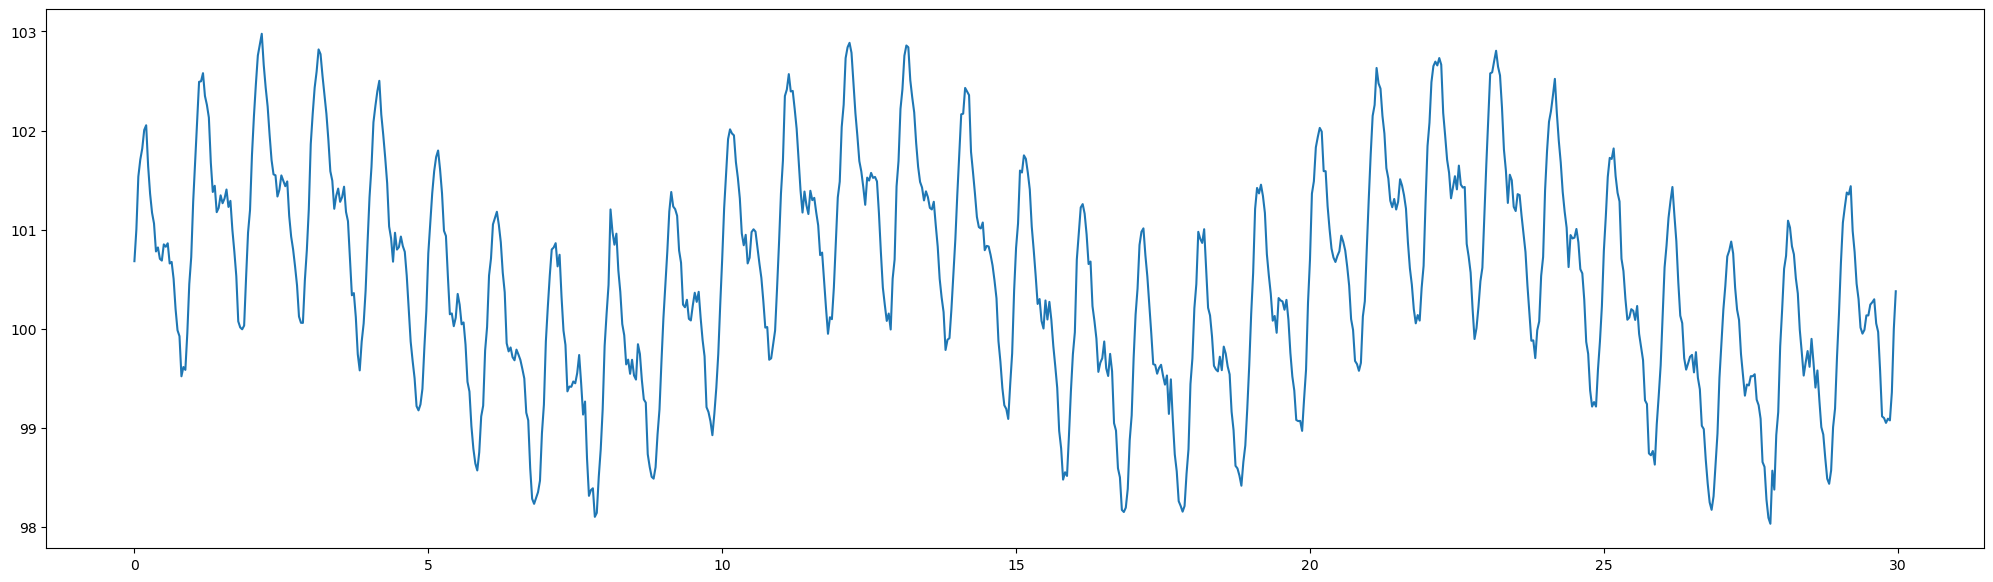

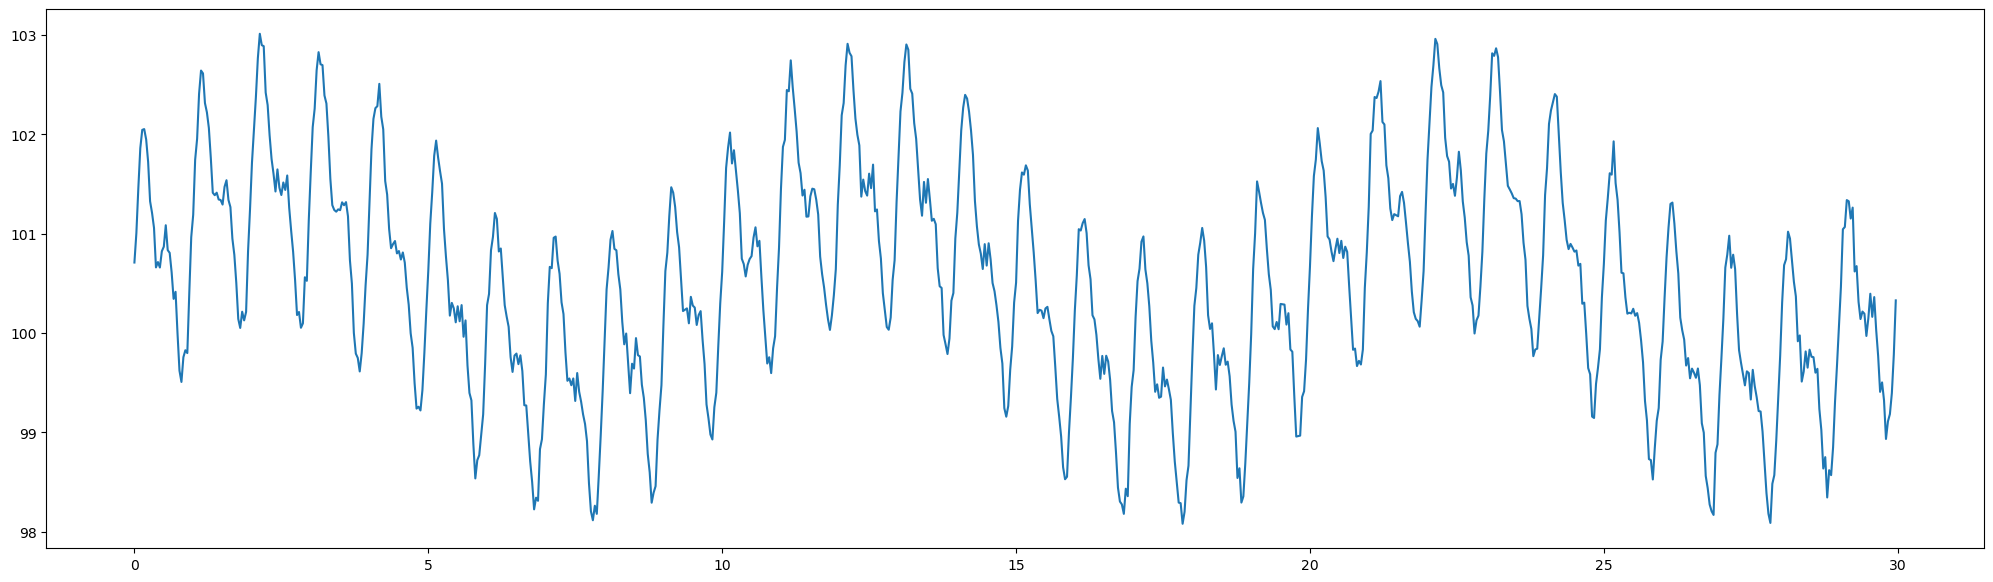

In [7]:
from pyampd.ampd import find_peaks #Normal AMPD algorithm
import matplotlib.pyplot as plt    #Plotting capabilities
import numpy as np                 #Mathematical operations on large arrays
from numpy import sin, pi, log10, log
import statistics                  #allows for statistical operations

#Let's keep all odd numbered sensor bands to be cerebral and even numbered bands to be abdominal
class One:
    signals = [[],[],[],[],[]] #First three for light intensity, 4th for voltage, 5th for temp
    filt_signals = [[],[],[]]
    absorbances = [[],[],[]]
    time = []
    R_peaks = []
    StO2 = []
    bpm = []
    hrv = []
    temp = []
    cs_ratio = []
    pair = ""
    stored_nums = [-1,-1, -1] #List order: peaks, StO2, cs_ratio (correspond to the numbers used for each function)
    batt = 0
class Two:
    signals = [[],[],[],[],[]]
    filt_signals = [[],[],[],[],[]]
    absorbances = [[],[],[]]
    time = []
    R_peaks = []
    StO2 = []
    bpm = []
    hrv = []
    temp = []
    cs_ratio = []
    pair = ""
    stored_nums = [-1,-1, -1]
    batt = 0
    
myDict = {"1": One, "2": Two}

def fake_timeseries(tmax=30, seed=None):
    '''
    This generates fake data for testing the code. The amount of readings it gives is the same as if we were using
    9600 baud rate with float numbers (300 readings per second).
    '''
    np.random.seed(seed)
    fs, f1, f2, f3, a, b, c, d = 300, 1, 2, 0.1, 1, 0.6, 1, 1.
    N = int(tmax*fs)
    t = np.linspace(0, tmax, N)
    x = a*sin(2*pi*f1*t) + b*sin(2*pi*f2*t) + c*sin(2*pi*f3*t) + d*np.random.rand(N) + 100
    return t, x

#Runs continuously
def avg_filter(band, num_measurements = 9):
    for i in range(0,5):
        total = 0
        for j in range(0,num_measurements):
            total += band.signals[i].pop(0) #Adds all the numbers in the list, then removes them
            
        band.filt_signals[i].append(total/num_measurements)
        
def calc_absorbance(band):
    I0 = 200
    for i in range(0,3):
        band.absorbances[i] += [np.log10(I0/I) for I in band.filt_signals[i]]

#Sleep 5 secs
def StO2(band):
    '''
    Refer to "Emily - Week 2 1/16" from Winter 2024 for the math.
    Reference: https://patentimages.storage.googleapis.com/1f/85/02/e884e4fec6d945/US6456862.pdf
    
    Absorbance coefficients for oxyhemoglobin and deoxyhemoglobin at 700 nm, 850 nm, & 890 nm, respectively.
    Reference: https://www.sciencedirect.com/science/article/pii/0005272888900692?via%3Dihub
    '''
    
    coeff_HbO2 = (0.421, 1.097, 1.226) #Tuples require less memory and are immutable
    coeff_Hb = (1.798, 0.781, 0.866)
    G = 1 #Arbitrary number for testing
    each_average_StO2 = []
    StO2_list = [[],[]]
    for i in range(0,3):
        if i == 2:
            for j in range(band.stored_nums[1],len(band.absorbances[0])):
                A1G_epsilons = (band.absorbances[0][j]-G) * (coeff_HbO2[0]*coeff_Hb[2] - coeff_HbO2[2]*coeff_Hb[0])
                A2Gs_epsilons = (band.absorbances[2][j]-G)*coeff_HbO2[0] - (band.absorbances[0][j]-G)*coeff_HbO2[2]
                StO2_frac = (A1G_epsilons - coeff_Hb[0]*A2Gs_epsilons)/(A1G_epsilons + A2Gs_epsilons*(coeff_HbO2[0]-coeff_Hb[0]))
                StO2_list[1].append(StO2_frac * 100)
        elif i == 0:
            for j in range(band.stored_nums[1],len(band.absorbances[i])):
                A1G_epsilons = (band.absorbances[i][j]-G) * (coeff_HbO2[i]*coeff_Hb[i+1] - coeff_HbO2[i+1]*coeff_Hb[i])
                A2Gs_epsilons = (band.absorbances[i+1][j]-G)*coeff_HbO2[i] - (band.absorbances[i][j]-G)*coeff_HbO2[i+1]
                StO2_frac = (A1G_epsilons - coeff_Hb[i]*A2Gs_epsilons)/(A1G_epsilons + A2Gs_epsilons*(coeff_HbO2[i]-coeff_Hb[i]))
                StO2_list[i].append(StO2_frac * 100)

    for k in range(0,len(StO2_list[0])):
        each_average_StO2.append((StO2_list[0][k] + StO2_list[1][k])/3)
    
    band.StO2.append(statistics.mean(each_average_StO2))
    band.stored_nums[1] += len(each_average_StO2)
        

#Sleep 5 secs
def peaks(band):
    #Returns the indices of occurance only in the new section
    signal_section = band.filt_signals[0][(band.stored_nums[0]+1):]
    new_peaks = list(find_peaks(signal_section))
    band.R_peaks = new_peaks
    band.stored_nums[0] += len(signal_section)
        

#Sleep 5 secs
def bpm(band): #pass in list of connected bands, pass in desired length of time, default 5 secs
    band.bpm.append(len(band.R_peaks)*12)
    

#Sleep 5 secs
def cs_ratio(band):
    if band == One:
        StO2_head = band.StO2[(band.stored_nums[2]+1)]
        StO2_stomach = myDict[band.pair].StO2[(band.stored_nums[2]+1)]
        band.cs_ratio.append(StO2_head/StO2_stomach)
        myDict[band.pair].cs_ratio.append(StO2_head/StO2_stomach)
        band.stored_nums[2] += 1

    
#Sleep 5 secs
def hrv(band):
    hrv_untranslated = statistics.mean(np.diff(band.R_peaks)) #np.diff determines the difference between each peak
    hrv_translated = hrv_untranslated*(10/3) #Need to translate indices to ms. Assuming 300 readings (indices) per sec
    band.hrv.append(hrv_translated)

    
def batt_percent(band):
    voltage = 0
    voltage_100 = 100
    for i in range(0,len(band.filt_signals[3])):
        voltage += band.filt_signals[3][i]
        
    band.batt = (2 * voltage / len(voltage) / 1000.0)/voltage_100 * 100
    

def temp(band):
    #From thermistor datasheet. Will change based on color code
    A = 3.354E-3
    B = 2.9339E-4
    C = 3.4943E-6
    D = -7.7126E-7
    R_ref = 1000
    band.temp.append(1/(A + B*log(band.filt_signals[4]/R_ref) + C*(log(band.filt_signals[4]/R_ref))^2 + D*(log(band.filt_signals[4]/R_ref))^3))

#Creating signal for band One
t0, x0 = fake_timeseries() #calling the function to make the fake signals
t1, x1 = fake_timeseries()
t2, x2 = fake_timeseries()
One.time = list(t0)

#Creating signal for band Two
t3, x3 = fake_timeseries()
t4, x4 = fake_timeseries()
t5, x5 = fake_timeseries()
Two.time = list(t3)

#User input and initialization
band_nums = []
user_input = input("Enter the numbers of the connected bands. Separate by spaces or commas: ")
my_string = user_input.replace(',',' ')
band_nums = [myDict[band_num] for band_num in my_string.split()] #myDict[band] translates the user input to the class names

user_input = input("Enter the numbers of the sensor bands that are on the same rat. Enter cerebral sensor band first. Separate with commas or spaces: ")
my_string = user_input.replace(',',' ')
pair_nums = my_string.split()
#Storing the pairs to call in the function and write to csv file later
myDict[pair_nums[0]].pair = pair_nums[1]
myDict[pair_nums[1]].pair = pair_nums[0]

#Data collection
length = 9
interval = 10
while length <= len(t0):
    One.signals[0] += list(x0)[length-interval+1:length]
    One.signals[1] += list(x1)[length-interval+1:length]
    One.signals[2] += list(x2)[length-interval+1:length]
    Two.signals[0] += list(x3)[length-interval+1:length]
    Two.signals[1] += list(x4)[length-interval+1:length]
    Two.signals[2] += list(x5)[length-interval+1:length]
        
    for band in band_nums: 
        avg_filter(band) #Takes every 10 readings and averages them to one
        calc_absorbance(band) #Converts intensity readings to absorbance
    
        if ((length+1) % 1500) == 0: #These only run every 5 seconds (every 1,500 readings)
            peaks(band)
            StO2(band)
            bpm(band)
            hrv(band)
            if len(myDict[band.pair].StO2) > 0: #Makes sure it doesn't run when the pair band.StO2 doesn't exist yet
                cs_ratio(band)
    
    length += interval

#Displaying Results
for band in band_nums:
    indices = list(range(0,len(band.filt_signals[0])))
    band.time = [index/30 for index in indices]
    print("")
    print("StO2: ", band.StO2)
    print("BPM: ", band.bpm)
    print("HRV: ", band.hrv)
    print("CS Ratio: ", band.cs_ratio)
    print("Pair band: ", band.pair)
    plt.figure(figsize=(25,7))
    plt.plot(band.time,band.filt_signals[0])